# Udacity - Self driving car
We are here building a minimal version of self driving car. With pictures of the front cameras of the car, a Deep Learning algorithm in computer predicts the steering angle to avoid all sorts of collisions. Predicting steering angle can be thought of as a regression problem. We will feed images to Convolutional Neural Network and the label will be the steering angle in that image. Model will learn the steering angle from the as per the turns in the image and will finally predicts steering angle for unknown images.

## Depedencies

In [9]:
import os
import cv2
import pandas as pd 
import numpy as np
import argparse
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from utils import SHAPE, batch_gen
import matplotlib.image as mpimg

## Parameters

In [13]:
NAME = "test"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
np.random.seed(0)

data_dir = 'C:/Users/hadri/Desktop/Udacity'
test_size = 0.2
keep_prob = 0.5
nb_epoch = 10
samples_per_epoch = 20000
batch_size = 40
learning_rate = 1.0e-4

## 1) Getting training and test set from data

In [7]:
def load_data():
    data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'),
                          names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    X = data_df[['center', 'left', 'right']].values
    y = data_df['steering'].values

    # devide between training and testing
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid

data = load_data()

## 2) Visualisation of the data

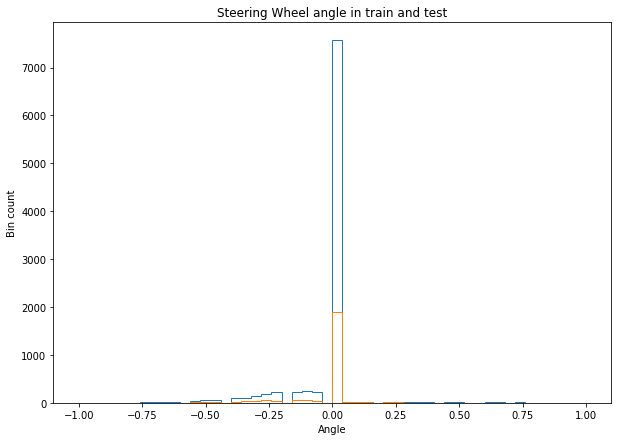

In [10]:
data = load_data()
fig = plt.figure(figsize = (10, 7))
plt.hist(data[2], bins = 50, histtype = "step")
plt.hist(data[3], bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

![texte](IMG/center_2019_06_17_22_31_06_993.jpg)

## 3) Preprocessing of the data

In [ ]:
SHAPE = (160, 320, 3)

def load_image(data_dir, image_file):
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def crop(img):
    cropped = img[60:-25, :, :]
    return cropped

def resize(img):
    resized = cv2.resize(img, (320, 160), cv2.INTER_AREA)
    return resized

def flip(image, steering_angle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def translate(data_dir, center, left, right, steering_angle):
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.1
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.1
    return load_image(data_dir, center), steering_angle

def preprocess(image):
    image = crop(image)
    image = resize(image)
    return image

def fill(data_dir, center, left, right, steering_angle):
    image, steering_angle = translate(data_dir, center, left, right, steering_angle) # left,right,center augmentation
    image, steering_angle = flip(image, steering_angle)                                 # flip augmentation
    return image, steering_angle


# Generate training image
def batch_gen(data_dir, image_paths, steering_angles, batch_size, is_training):
    images = np.empty([batch_size, 160, 320, 3])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]

            # argumentation only if is in training
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = fill(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 

            # preprocessing
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
yield images, steers

In [ ]:
def train_model(model, X_train, X_valid, y_train, y_valid):
    # Saves the model after every epoch.
    checkpoint = ModelCheckpoint('model_test-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

    # MSE + adaptive gradient descent
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

    #Fit model with the generated, augmented, data in batches
    model.fit_generator(batch_gen(data_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batch_gen(data_dir, X_valid, y_valid, batch_size, False),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint, tensorboard],
                        verbose=1)

## Basic model

In [ ]:
model0 = Sequential()
model0.add(Conv2D(2, 3, 3, activation='relu', subsample=(2, 2)))
model0.add(MaxPooling2D((4,4),(4,4),'valid'))
model0.add(Dropout(0.25))
model0.add(Flatten())
model0.add(Dense(1))
model0.summary()
train_model(model, *data)

## VGGNet (2014)
VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. Similar to AlexNet, only 3x3 convolutions, but lots of filters. Trained on 4 GPUs for 2–3 weeks. It is currently the most preferred choice in the community for extracting features from images. The weight configuration of the VGGNet is publicly available and has been used in many other applications and challenges as a baseline feature extractor. However, VGGNet consists of 138 million parameters, which can be a bit challenging to handle.
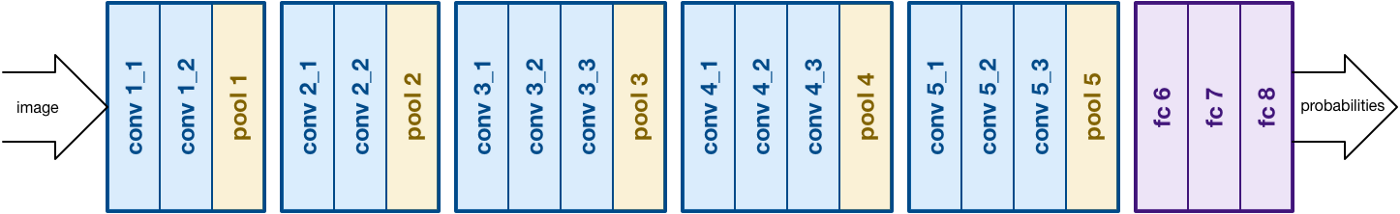

In [ ]:
model=Sequential()
model.add(Conv2D(32, 3,3 ,activation='relu',input_shape=(64, 64, 3),border_mode='same'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(64,3,3,activation='relu',border_mode='same'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(128,3,3,activation='relu',border_mode='same'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.summary()
train_model(model, *data)